# Click Consensus

Banfield et al. (2015) compute the *consensus* for each subject. Consensus is defined as

$$
C = \frac{n_c}{n}
$$

where $n_c$ is the number of volunteers who agreed on the majority classification of a subject, and $n$ is the total number of volunteers who attempted to classify the subject.

There are two components to a classification. The first is the combination of radio components that correspond with a single source. There are often multiple radio contours per subject, and volunteers must decide which contours correspond with the same source. The second is the host galaxy selection. This is represented by volunteers clicking on the infrared image to identify a host galaxy.

Banfield et al. compute $n_c$ by counting how many volunteers agree on the combination of radio components and the host galaxy ID for all radio components in the subject. However, the associated code seems to ignore the amount of agreement on host galaxy location while computing $n_c$. In this notebook, I will compute a mean consensus that includes agreement on host galaxy location, and compare this to the value obtained in the paper.

The method used by Banfield et al. to identify a host galaxy from many volunteers' clicks is as follows. A kernel density estimator is applied to the volunteers' clicks. The density is estimated for all pixels in the image. A local maximum filter is applied to the density to find click density peaks. This yields a) the number of different objects clicked on, and b) the location of the infrared host galaxy (by finding the maximum peak). No method is described for deciding which host was clicked on by any particular volunteer. Additionally, this method is somewhat slow due to computing the density across 250000 data points per subject, and somewhat fragile as two volunteers clicking on the same location will result in an invalid density estimation. In this notebook, I will use a different method to identify the host galaxy that attempts to solve both of these problems, and also provides a mechanism for finding which host was clicked on by any given volunteer. I will use $k$-means clustering to cluster the clicks, then fit a gaussian to each cluster. The mean of the gaussian represents the infrared host associated with each cluster, and the cluster membership of a click allows us to find the infrared host associated with each click. This can then be used to calculate $n_c$ and hence consensus.

## Values of $k$

The first question is, "what should $k$ be?". It would be nice to know what values of $k$ are realistic for the dataset. Fortunately, the number of click peaks is output by Willett's RGZ consensus calculation, so we can just run that over a thousand or so subjects and find the max.

In [124]:
import collections
import pprint
import sys

import matplotlib.pyplot
import numpy
import scipy.stats
import sklearn.cluster
import sklearn.mixture

%matplotlib inline

sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.show
import crowdastro.rgz_analysis.consensus

In [2]:
# This takes a while to run.
if False:
    largest_n_peaks = 0
    n = 300
    for subject in crowdastro.data.db.radio_subjects.find({'metadata.survey': 'atlas'}).limit(n):
        consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
        for answer in consensus['answer'].values():
            n_peaks = answer.get('peak_data', {}).get('npeaks', 0)
            if n_peaks > largest_n_peaks:
                largest_n_peaks = n_peaks
                print('New max: {} ({})'.format(n_peaks, subject['zooniverse_id']))

That's unexpectedly high. Let's have a look at ARG0003rls (74 clicks!) &mdash; maybe it's special in some way, or maybe KDE fails for it and we get strange results.

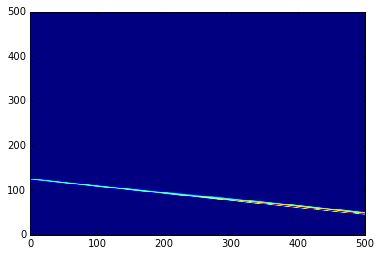

In [3]:
s = crowdastro.data.db.radio_subjects.find_one({'zooniverse_id': 'ARG0003rls'})
c = crowdastro.rgz_analysis.consensus.consensus(s['zooniverse_id'])
matplotlib.pyplot.pcolor(c['answer'][636.233]['peak_data']['Z'])
matplotlib.pyplot.show()

So it looks like KDE failed. Perhaps there were very few clicks?

In [4]:
s['classification_count']

22

Let's plot the clicks and look.

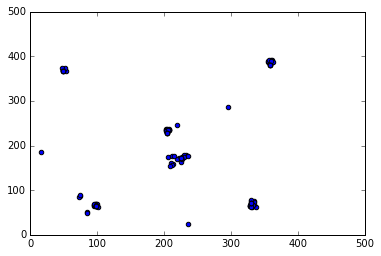

In [5]:
classifications = crowdastro.data.db.radio_classifications.find({'subject_ids': s['_id']})
xs = []
ys = []
for classification in classifications:
    clicksets = [a['ir'] for a in classification['annotations'] if 'ir' in a]
    for clicks in clicksets:
        if clicks != 'No Sources':
            for click in clicks.values():
                xs.append(float(click['x']))
                ys.append(float(click['y']))
matplotlib.pyplot.scatter(xs, ys)
matplotlib.pyplot.xlim((0, 500))
matplotlib.pyplot.ylim((0, 500))
matplotlib.pyplot.show()

Maybe the clicks overlap, and as a result, KDE breaks? We can check this.

In [6]:
l = len(list(zip(xs, ys))) - len(set(zip(xs, ys)))
assert l == 0, l

AssertionError: 19

It seems that 19 people clicked on the same point, and this broke KDE.

## PG-means clustering

We will now follow the PG-means clustering algorithm to cluster the clicks. I can't test this on the same subject used in Banfield et al. (2015), since that's not from the ATLAS survey, but I'll find a subject and use that.

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


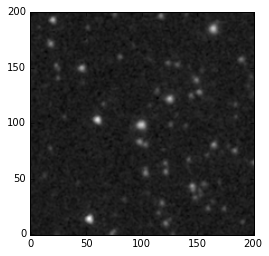

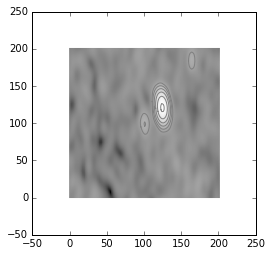

In [7]:
# subject = crowdastro.data.get_random_subject()
subject = crowdastro.data.db.radio_subjects.find_one({'zooniverse_id': 'ARG0003sfk'})
crowdastro.show.ir(subject)
matplotlib.pyplot.show()
crowdastro.show.radio(subject)
crowdastro.show.contours(subject)
matplotlib.pyplot.show()

Let's see what Willett's code gives us.

In [8]:
consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
for answer in consensus['answer'].values():
    print(answer['peak_data']['npeaks'])

2
2
1


Let's start by pulling out all the radio classifications and finding the plurality classification.

In [9]:
def make_annotation_signature(annotation):
    """Generates the signature associated with an annotation."""
    if 'radio' not in annotation:
        # Metadata (ignore this).
        return None

    # We want to turn the radio classifications into a unique signature. I can just take all the xmax's and ymax's
    # and put them into some tuples (xmaxs, ymaxs).
    xmaxs = tuple(sorted([round(float(r['xmax']), 14) for r in annotation['radio'].values()]))
    ymaxs = tuple(sorted([round(float(r['ymax']), 14) for r in annotation['radio'].values()]))
    signature = (xmaxs, ymaxs)
    return signature

def make_classification_signature(classification):
    """Generates the signature associated with a radio classification."""
    classification_signature = []
    for annotation in classification['annotations']:
        annotation_signature = make_annotation_signature(annotation)
        if annotation_signature is not None:
            classification_signature.append(annotation_signature)

    classification_signature = tuple(sorted(classification_signature))
    return classification_signature


n_signatures = collections.Counter()

for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
    classification_signature = make_classification_signature(classification)
    n_signatures[classification_signature] += 1

plurality_radio_signature = max(n_signatures, key=n_signatures.get)

Now we need to cluster the clicks of anyone who agreed with the plurality radio signature. In general, there might be multiple clicks. Willett chooses to just use the first click, so we'll do that too. While we're here, we'll check that dividing out the number of people who agree with the plurality radio signature by the total number of classifications gives us the same consensus value as the original code.

Consensus (MatthewJA): 60.00%
Consensus (willettk): 63.16%


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


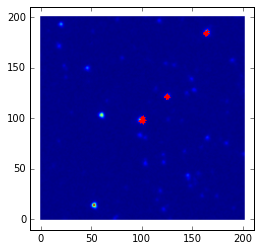

In [106]:
n_agree = 0
n_total = 0
signature_to_clicks = collections.defaultdict(list)
for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
    classification_signature = make_classification_signature(classification)
    if classification_signature == plurality_radio_signature:
        n_agree += 1
        # Format: [{'ir': {id: {'y': y}}}]
        # We'll need to pull out a {signature: [coords_of_first_click]} map to be consistent - each signature should
        # have a different set of clusters, as it represents a different object.
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue
            
            first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
            signature_to_clicks[annotation_signature].append(first_click)

    n_total += 1

original_consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
original_consensus = original_consensus['n_users'] / original_consensus['n_total']
print('Consensus (MatthewJA): {:.02%}'.format(n_agree / n_total))
print('Consensus (willettk): {:.02%}'.format(original_consensus))

ir = crowdastro.data.get_ir(subject)
matplotlib.pyplot.imshow(ir, origin='lower')
for clicks in signature_to_clicks.values():
    clicks = numpy.array(clicks, dtype=float)
    clicks *= crowdastro.config.get('click_to_fits')
    clicks[:, 1] = 200 - clicks[:, 1]
    matplotlib.pyplot.scatter(clicks[:, 0], clicks[:, 1], marker='+', c='r')
matplotlib.pyplot.show()

It seems I have an extra data point that the RGZ code discards. I'm not sure why (or if it matters) so I'll investigate that later. The clicks work fine. Now I'll implement the PG-means algorithm and run it on the clicks.

In [151]:
class Cluster(object):
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
    
    def __repr__(self):
        return 'Cluster({}, {})'.format(self.mean, self.cov)
    
    def project(self, projection_vector):
        return Cluster(self.mean @ projection_vector,
                       self.cov @ projection_vector @ projection_vector)

def pg_means(points, significance=0.05, projections=12):
    """Cluster points with the PG-means algorithm."""
    # Initialise one cluster with mean and covariance of the data.
    clusters = [Cluster(numpy.mean(points, axis=0), numpy.cov(points.T))]
    clustered_points = [list(range(points.shape[0]))]
    
    assert clusters[0].mean.shape == (2,)
    assert clusters[0].cov.shape == (2, 2)
    
    while True:
        for _ in range(projections):
            # Project data and model to one dimension.
            # We'll use a random unit vector to project against.
            projection_vector = numpy.random.random(size=(2,))
            projected_data = points @ projection_vector
            projected_clusters = [c.project(projection_vector) for c in clusters]

            # KS test the projected model against the projected dataset.
            for index, projected_cluster in enumerate(projected_clusters):
                projected_clustered_points = projected_data[clustered_points[index]]
                mean = projected_cluster.mean
                stdev = numpy.sqrt(projected_cluster.cov)
                _, p_value = scipy.stats.kstest(projected_data, 'norm', args=(mean, stdev))
                if p_value < significance:
                    # Reject the null hypothesis.
                    break
            else:
                # This is gaussian.
                continue

            # Reject the null hypothesis.
            print('Rejecting the null hypothesis.')
            break

        else:
            # Stop and return the model.
            return clusters

        # A test rejected the null hypothesis.
        # Run (k + 1)-means clustering on the data.
        k = len(clusters) + 1
        print(k)
        kmc = sklearn.cluster.KMeans(n_clusters=k)
        kmc.fit(points)
        clustered_points = [[] for _ in range(k)]
        for index, cluster in enumerate(kmc.predict(points)):
            clustered_points[cluster].append(index)
        clusters = []
        for index, mean in enumerate(kmc.cluster_centers_):
            points_in_cluster = points[clustered_points[index]]
            cov = numpy.cov(points_in_cluster.T)
            clusters.append(Cluster(mean, cov))

# clicks = numpy.array(signature_to_clicks[((168.52139993210605,), (27.36430937927985,))], dtype=float)
clicks = numpy.concatenate(list(signature_to_clicks.values()))
pg_means(clicks)

Rejecting the null hypothesis.
2
Rejecting the null hypothesis.
3
Rejecting the null hypothesis.
4
Rejecting the null hypothesis.
5
Rejecting the null hypothesis.
6
Rejecting the null hypothesis.
7
Rejecting the null hypothesis.
8
Rejecting the null hypothesis.
9
Rejecting the null hypothesis.
10
Rejecting the null hypothesis.
11
Rejecting the null hypothesis.
12
Rejecting the null hypothesis.
13
Rejecting the null hypothesis.
14
Rejecting the null hypothesis.
15
Rejecting the null hypothesis.
16
Rejecting the null hypothesis.
17
Rejecting the null hypothesis.
18
Rejecting the null hypothesis.
19
Rejecting the null hypothesis.
20
Rejecting the null hypothesis.
21
Rejecting the null hypothesis.
22
Rejecting the null hypothesis.
23
Rejecting the null hypothesis.
24
Rejecting the null hypothesis.
25
Rejecting the null hypothesis.
26
Rejecting the null hypothesis.
27
Rejecting the null hypothesis.
28
Rejecting the null hypothesis.
29
Rejecting the null hypothesis.
30
Rejecting the null hyp

K:\Languages\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2079: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


[Cluster([ 262.5  165. ], [[ nan  nan]
  [ nan  nan]]), Cluster([ 348.   33.], [[ nan  nan]
  [ nan  nan]]), Cluster([ 213.44094849  215.22221375], [[ nan  nan]
  [ nan  nan]]), Cluster([ 210.5   216.75], [[ nan  nan]
  [ nan  nan]]), Cluster([ 214.5  210. ], [[ nan  nan]
  [ nan  nan]]), Cluster([ 263.5  168. ], [[ 0.  0.]
  [ 0.  0.]]), Cluster([ 344.58334351   33.41667175], [[ nan  nan]
  [ nan  nan]]), Cluster([ 349.44094849   29.22221375], [[ nan  nan]
  [ nan  nan]]), Cluster([ 211.58334351  212.41667175], [[ nan  nan]
  [ nan  nan]]), Cluster([ 213.5  221. ], [[ nan  nan]
  [ nan  nan]]), Cluster([ 264.58334351  166.41667175], [[ nan  nan]
  [ nan  nan]]), Cluster([ 217.  216.], [[ nan  nan]
  [ nan  nan]]), Cluster([ 208.  218.], [[ nan  nan]
  [ nan  nan]]), Cluster([ 267.  168.], [[ nan  nan]
  [ nan  nan]]), Cluster([ 265.44094849  164.22221375], [[ nan  nan]
  [ nan  nan]]), Cluster([ 345.5   31. ], [[ nan  nan]
  [ nan  nan]]), Cluster([ 346.5    33.75], [[ nan  nan]
  [ n